In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# --- Data Loading and Preparation ---
btc_df = pd.read_csv("BTC.csv")
eth_df = pd.read_csv("ETH.csv")

In [ ]:
# Convert timestamp to datetime and set as index
btc_df['timestamp'] = pd.to_datetime(btc_df['timestamp']).dt.normalize()
eth_df['timestamp'] = pd.to_datetime(eth_df['timestamp']).dt.normalize()
#btc_df.set_index('timestamp', inplace=True)
#eth_df.set_index('timestamp', inplace=True)

In [ ]:
def calculate_volatility_metrics(df, asset_name='Asset'):
    """
    Calculate multiple volatility metrics for cryptocurrency data

    Parameters:
    df: DataFrame with OHLCV data and timestamp
    asset_name: Name of the asset for labeling

    Returns:
    dict: Dictionary containing volatility metrics and interpretations
    """

    # Ensure timestamp is datetime
    df = df.copy()
    if not pd.api.types.is_datetime64_any_dtype(df['timestamp']):
        df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Sort by timestamp
    df = df.sort_values('timestamp').reset_index(drop=True)

    # Calculate returns
    df['daily_return'] = df['close'].pct_change()
    df['log_return'] = np.log(df['close'] / df['close'].shift(1))

    # Calculate intraday volatility (High-Low range)
    df['intraday_volatility'] = (df['high'] - df['low']) / df['close']

    # 1. Historical Volatility (annualized standard deviation of returns)
    # Using 365 days for crypto (trades 24/7)
    daily_vol = df['daily_return'].std()
    annualized_vol = daily_vol * np.sqrt(365)

    # 2. Rolling volatility (30-day window)
    df['rolling_vol_30d'] = df['daily_return'].rolling(window=30).std() * np.sqrt(365)

    # 3. Parkinson's volatility (uses high-low range, more efficient estimator)
    df['parkinson_vol'] = np.sqrt((1/(4*np.log(2))) * np.log(df['high']/df['low'])**2)
    parkinson_vol_annualized = df['parkinson_vol'].mean() * np.sqrt(365)

    # 4. Average True Range (ATR) - normalized
    df['tr'] = np.maximum(
        df['high'] - df['low'],
        np.maximum(
            abs(df['high'] - df['close'].shift(1)),
            abs(df['low'] - df['close'].shift(1))
        )
    )
    atr_14 = df['tr'].rolling(window=14).mean().iloc[-1]
    atr_normalized = (atr_14 / df['close'].iloc[-1]) * 100

    # Calculate volatility regime
    current_vol = df['rolling_vol_30d'].iloc[-1]
    median_vol = df['rolling_vol_30d'].median()

    if current_vol > median_vol * 1.5:
        regime = "High Volatility"
        regime_color = "red"
    elif current_vol < median_vol * 0.7:
        regime = "Low Volatility"
        regime_color = "green"
    else:
        regime = "Normal Volatility"
        regime_color = "orange"

    # Volatility trend (increasing or decreasing)
    recent_vol = df['rolling_vol_30d'].iloc[-30:].mean()
    older_vol = df['rolling_vol_30d'].iloc[-90:-30].mean()
    vol_trend = "Increasing" if recent_vol > older_vol else "Decreasing"

    # Results dictionary
    results = {
        'asset_name': asset_name,
        'annualized_volatility': annualized_vol,
        'current_30d_volatility': current_vol,
        'parkinson_volatility': parkinson_vol_annualized,
        'atr_14_normalized': atr_normalized,
        'median_volatility': median_vol,
        'volatility_regime': regime,
        'volatility_trend': vol_trend,
        'avg_intraday_volatility': df['intraday_volatility'].mean() * 100,
        'max_daily_return': df['daily_return'].max() * 100,
        'min_daily_return': df['daily_return'].min() * 100,
        'dataframe': df
    }

    # Print interpretation
    print(f"\n{'='*60}")
    print(f"VOLATILITY ANALYSIS: {asset_name}")
    print(f"{'='*60}")
    print(f"\n📊 Key Metrics:")
    print(f"  • Annualized Volatility: {annualized_vol:.2%}")
    print(f"  • Current 30-Day Vol:    {current_vol:.2%}")
    print(f"  • Parkinson Volatility:  {parkinson_vol_annualized:.2%}")
    print(f"  • ATR (14-day, %):       {atr_normalized:.2f}%")
    print(f"  • Avg Intraday Range:    {results['avg_intraday_volatility']:.2f}%")

    print(f"\n📈 Market Regime: {regime} ({vol_trend})")
    print(f"  • Current vol vs median: {(current_vol/median_vol - 1)*100:+.1f}%")

    print(f"\n🎯 Risk Context:")
    if annualized_vol < 0.30:
        print(f"  • Low volatility period - good for stable strategies")
    elif annualized_vol < 0.60:
        print(f"  • Moderate volatility - typical crypto market")
    else:
        print(f"  • High volatility - elevated risk and opportunity")

    print(f"\n⚡ Extreme Moves:")
    print(f"  • Best daily gain:  {results['max_daily_return']:+.2f}%")
    print(f"  • Worst daily loss: {results['min_daily_return']:+.2f}%")

    return results

In [ ]:
def plot_volatility_analysis(btc_results, eth_results):
    """
    Create comprehensive volatility comparison plots
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('BTC vs ETH Volatility Analysis', fontsize=16, fontweight='bold')

    btc_df = btc_results['dataframe']
    eth_df = eth_results['dataframe']

    # Plot 1: Rolling 30-day volatility comparison
    ax1 = axes[0, 0]
    ax1.plot(btc_df['timestamp'], btc_df['rolling_vol_30d'],
             label='BTC', color='orange', linewidth=2)
    ax1.plot(eth_df['timestamp'], eth_df['rolling_vol_30d'],
             label='ETH', color='black', linewidth=2)
    ax1.set_title('30-Day Rolling Volatility (Annualized)', fontweight='bold')
    ax1.set_ylabel('Volatility')
    ax1.legend()
    ax1.grid(alpha=0.3)
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

    # Plot 2: Volatility comparison bar chart
    ax2 = axes[0, 1]
    metrics = ['Annualized\nVolatility', 'Current\n30-Day Vol', 'Parkinson\nVolatility']
    btc_vals = [btc_results['annualized_volatility'],
                btc_results['current_30d_volatility'],
                btc_results['parkinson_volatility']]
    eth_vals = [eth_results['annualized_volatility'],
                eth_results['current_30d_volatility'],
                eth_results['parkinson_volatility']]

    x = np.arange(len(metrics))
    width = 0.35
    ax2.bar(x - width/2, btc_vals, width, label='BTC', color='orange', alpha=0.8)
    ax2.bar(x + width/2, eth_vals, width, label='ETH', color='black', alpha=0.8)
    ax2.set_title('Volatility Metrics Comparison', fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(metrics)
    ax2.legend()
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
    ax2.grid(axis='y', alpha=0.3)

    # Plot 3: Distribution of daily returns
    ax3 = axes[1, 0]
    ax3.hist(btc_df['daily_return'].dropna(), bins=50, alpha=0.8,
             label='BTC', color='orange', density=True)
    ax3.hist(eth_df['daily_return'].dropna(), bins=50, alpha=0.6,
             label='ETH', color='black', density=True)
    ax3.set_title('Distribution of Daily Returns', fontweight='bold')
    ax3.set_xlabel('Daily Return')
    ax3.set_ylabel('Density')
    ax3.legend()
    ax3.grid(alpha=0.3)
    ax3.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1%}'))

    # Plot 4: Intraday volatility (High-Low range)
    ax4 = axes[1, 1]
    btc_intraday = btc_df['intraday_volatility'].rolling(window=30).mean()
    eth_intraday = eth_df['intraday_volatility'].rolling(window=30).mean()
    ax4.plot(btc_df['timestamp'], btc_intraday,
             label='BTC', color='orange', linewidth=2)
    ax4.plot(eth_df['timestamp'], eth_intraday,
             label='ETH', color='black', linewidth=2)
    ax4.set_title('Average Intraday Volatility (30-day MA)', fontweight='bold')
    ax4.set_ylabel('High-Low Range / Close')
    ax4.legend()
    ax4.grid(alpha=0.3)
    ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1%}'))

    plt.tight_layout()
    plt.show()



VOLATILITY ANALYSIS: Bitcoin (BTC)

📊 Key Metrics:
  • Annualized Volatility: 91.38%
  • Current 30-Day Vol:    31.11%
  • Parkinson Volatility:  93.49%
  • ATR (14-day, %):       1.76%
  • Avg Intraday Range:    8.17%

📈 Market Regime: Low Volatility (Decreasing)
  • Current vol vs median: -49.9%

🎯 Risk Context:
  • High volatility - elevated risk and opportunity

⚡ Extreme Moves:
  • Best daily gain:  +48.47%
  • Worst daily loss: -49.09%

VOLATILITY ANALYSIS: Ethereum (ETH)

📊 Key Metrics:
  • Annualized Volatility: 103.52%
  • Current 30-Day Vol:    63.64%
  • Parkinson Volatility:  76.04%
  • ATR (14-day, %):       3.72%
  • Avg Intraday Range:    6.63%

📈 Market Regime: Normal Volatility (Decreasing)
  • Current vol vs median: -21.8%

🎯 Risk Context:
  • High volatility - elevated risk and opportunity

⚡ Extreme Moves:
  • Best daily gain:  +50.73%
  • Worst daily loss: -42.35%


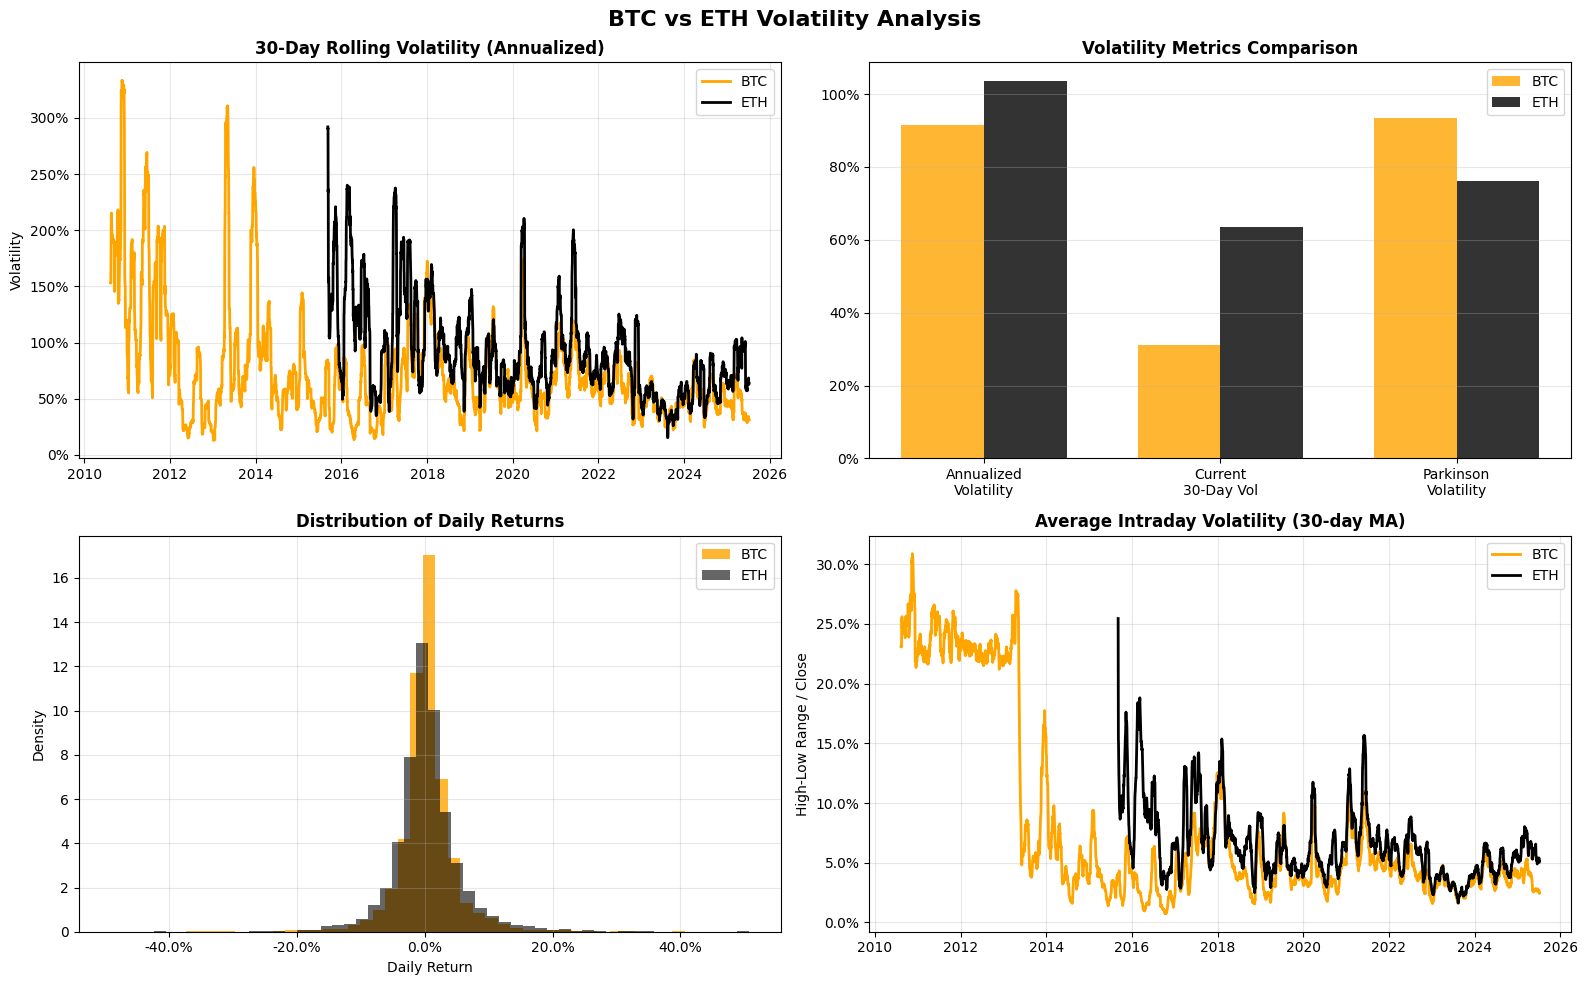

In [ ]:
# Example usage:
btc_vol = calculate_volatility_metrics(btc_df, 'Bitcoin (BTC)')
eth_vol = calculate_volatility_metrics(eth_df, 'Ethereum (ETH)')
plot_volatility_analysis(btc_vol, eth_vol)


##📈**1- BTC vs ETH Volatility: Key Insights**

Ethereum is historically more volatile than Bitcoin (103.5% vs 91.4% annualized), confirming ETH's reputation as the "riskier" asset. However, the current market tells a different story: BTC is experiencing exceptionally low volatility (31% - half its historical average), while ETH maintains more typical volatility levels (64%). This divergence suggests BTC has entered a consolidation phase, potentially indicating market maturity or accumulation, whereas ETH remains in a more active price discovery mode.

The trend is decreasing for both assets, signaling overall market stabilization. Notably, ETH's higher current ATR (3.72% vs 1.76%) means day-to-day price swings are roughly twice as large, presenting both higher risk and greater short-term trading opportunities. The distribution charts reveal both assets have similar downside risk (around -45% worst days), but ETH has demonstrated slightly more extreme upside potential (+50.7% vs +48.5% best days).

Bottom line for traders/investors: BTC is currently in a "quiet" phase ideal for position building with lower risk, while ETH offers more active trading opportunities with commensurately higher risk. The historical volatility gap (12 percentage points) suggests that over longer timeframes, ETH positions should be sized smaller than BTC positions to maintain equivalent risk exposure in a portfolio context.

This divergence also explains why BTC is often considered "digital gold" (store of value with stabilizing volatility), while ETH behaves more like a growth/technology asset with persistent elevated volatility driven by its active ecosystem development and smart contract platform dynamics.


CORRELATION ANALYSIS: BTC vs ETH

📊 Overall Correlations:
  • Price Correlation:      0.855
  • Return Correlation:     0.586 (Pearson)
  • Return Correlation:     0.643 (Spearman)
  • Volume Correlation:     0.912

📈 Current Market:
  • 30-Day Correlation:     0.861
  • 90-Day Median:          0.808
  • Correlation Regime:     Very High Correlation
  • Stability (StdDev):     0.294

🐂🐻 Market Regime Analysis:
  • Bull Market Correlation: 0.477
  • Bear Market Correlation: 0.716
  → Assets move MORE together in bear markets (+0.239)

⏱️  Lead-Lag Relationship:
  • No significant lead-lag relationship
  • Simultaneous Correlation: 0.586

📐 BTC Beta to ETH:
  • Beta:                   0.386
  • R-squared:              0.343
  → BTC is 0.39x as volatile as ETH (dampened moves)

💡 Diversification Insight:
  • Good diversification benefit
  • Assets have independent movements


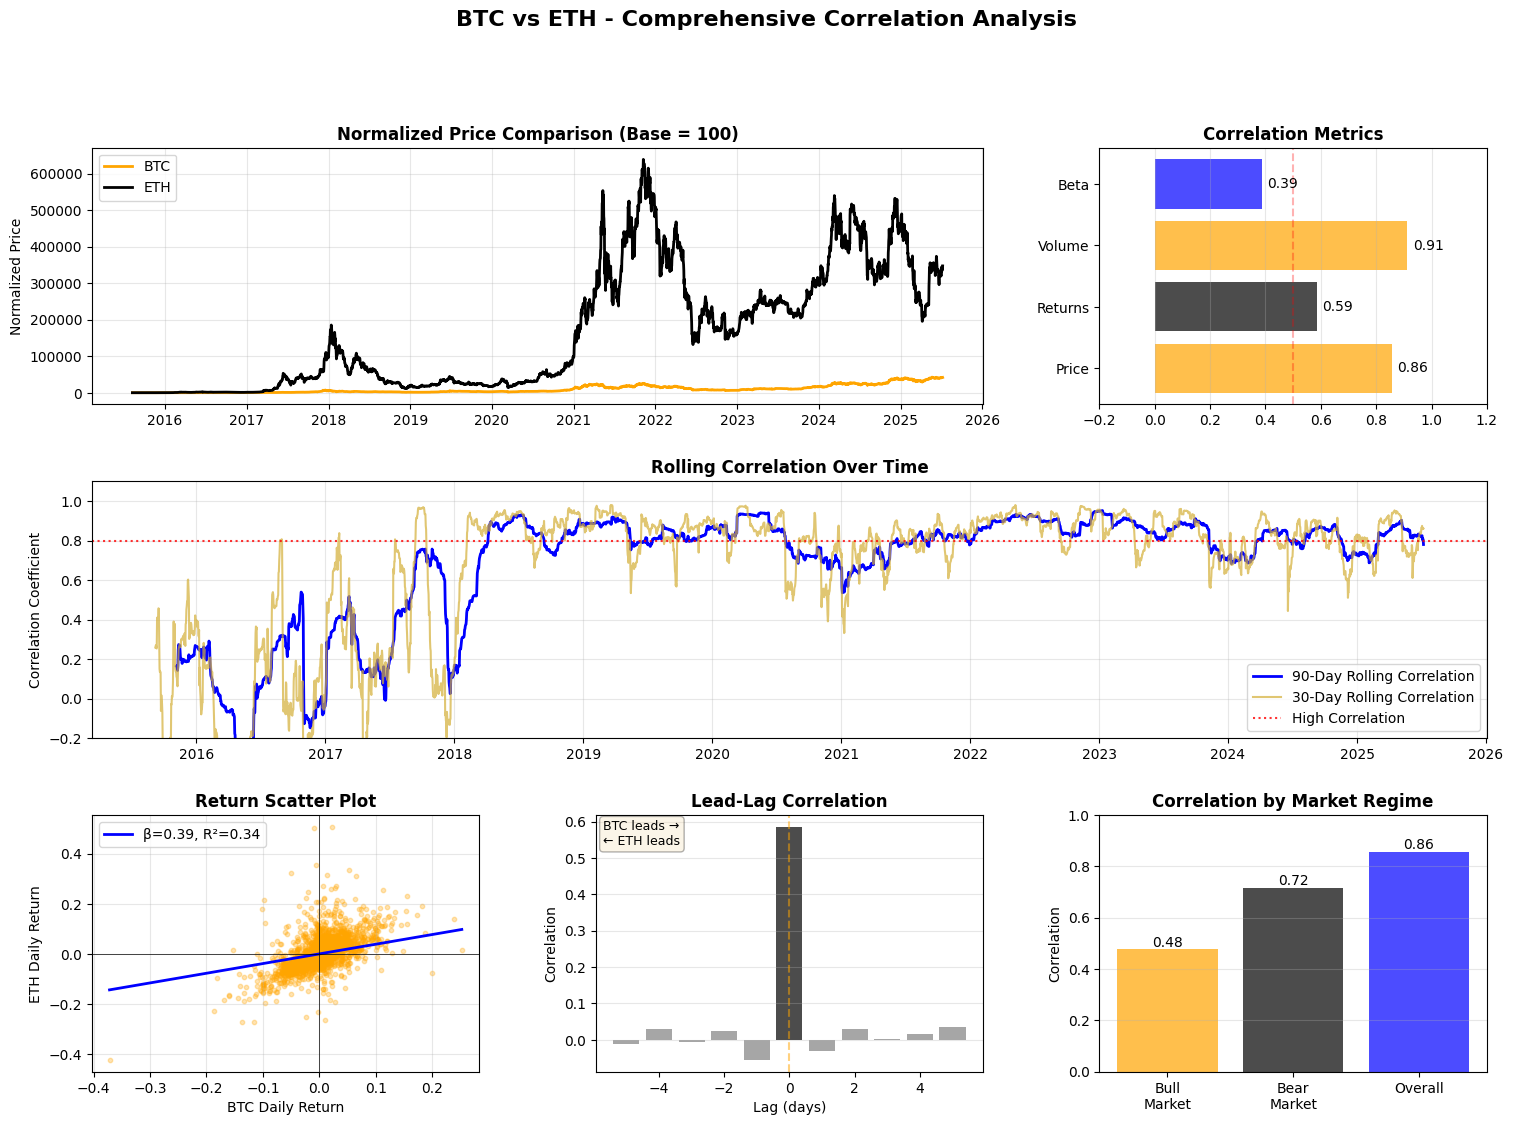

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def calculate_correlation_analysis(btc_df, eth_df):
    """
    Comprehensive correlation analysis between BTC and ETH

    Parameters:
    btc_df: DataFrame with BTC OHLCV data and timestamp
    eth_df: DataFrame with ETH OHLCV data and timestamp

    Returns:
    dict: Dictionary containing correlation metrics and interpretations
    """

    # Prepare data
    btc = btc_df.copy()
    eth = eth_df.copy()

    # Ensure timestamps are datetime
    if not pd.api.types.is_datetime64_any_dtype(btc['timestamp']):
        btc['timestamp'] = pd.to_datetime(btc['timestamp'])
    if not pd.api.types.is_datetime64_any_dtype(eth['timestamp']):
        eth['timestamp'] = pd.to_datetime(eth['timestamp'])

    # Merge on timestamp
    merged = pd.merge(
        btc[['timestamp', 'close', 'volume', 'marketCap']],
        eth[['timestamp', 'close', 'volume', 'marketCap']],
        on='timestamp',
        suffixes=('_btc', '_eth')
    ).sort_values('timestamp').reset_index(drop=True)

    # Calculate returns
    merged['return_btc'] = merged['close_btc'].pct_change()
    merged['return_eth'] = merged['close_eth'].pct_change()

    # Calculate log returns
    merged['log_return_btc'] = np.log(merged['close_btc'] / merged['close_btc'].shift(1))
    merged['log_return_eth'] = np.log(merged['close_eth'] / merged['close_eth'].shift(1))

    # 1. Overall Correlation (Pearson)
    price_corr = merged['close_btc'].corr(merged['close_eth'])
    return_corr = merged['return_btc'].corr(merged['return_eth'])
    volume_corr = merged['volume_btc'].corr(merged['volume_eth'])

    # 2. Spearman Correlation (rank-based, more robust to outliers)
    spearman_return_corr = merged['return_btc'].corr(merged['return_eth'], method='spearman')

    # 3. Rolling Correlation (90-day window)
    merged['rolling_corr_90d'] = merged['return_btc'].rolling(window=90).corr(
        merged['return_eth']
    )

    # 4. Rolling Correlation (30-day window)
    merged['rolling_corr_30d'] = merged['return_btc'].rolling(window=30).corr(
        merged['return_eth']
    )

    # 5. Correlation by market regime (bull vs bear)
    merged['btc_regime'] = np.where(
        merged['return_btc'].rolling(30).mean() > 0,
        'Bull',
        'Bear'
    )

    bull_corr = merged[merged['btc_regime'] == 'Bull']['return_btc'].corr(
        merged[merged['btc_regime'] == 'Bull']['return_eth']
    )
    bear_corr = merged[merged['btc_regime'] == 'Bear']['return_btc'].corr(
        merged[merged['btc_regime'] == 'Bear']['return_eth']
    )

    # 6. Lagged Correlation (does BTC lead ETH?)
    lag_correlations = {}
    for lag in range(-5, 6):
        if lag < 0:
            # ETH leads BTC
            corr = merged['return_btc'].corr(merged['return_eth'].shift(-lag))
        else:
            # BTC leads ETH
            corr = merged['return_btc'].shift(lag).corr(merged['return_eth'])
        lag_correlations[lag] = corr

    # Find best lag
    best_lag = max(lag_correlations.items(), key=lambda x: abs(x[1]))

    # 7. Correlation stability (standard deviation of rolling correlation)
    corr_stability = merged['rolling_corr_90d'].std()

    # 8. Current correlation regime
    current_corr = merged['rolling_corr_30d'].iloc[-1]
    median_corr = merged['rolling_corr_90d'].median()

    if current_corr > 0.8:
        corr_regime = "Very High Correlation"
    elif current_corr > 0.6:
        corr_regime = "High Correlation"
    elif current_corr > 0.4:
        corr_regime = "Moderate Correlation"
    elif current_corr > 0.2:
        corr_regime = "Low Correlation"
    else:
        corr_regime = "Very Low/Negative Correlation"

    # 9. Beta (ETH relative to BTC)
    # Remove NaN values for regression
    valid_data = merged[['return_btc', 'return_eth']].dropna()
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        valid_data['return_eth'],
        valid_data['return_btc']
    )
    beta = slope

    # Results dictionary
    results = {
        'price_correlation': price_corr,
        'return_correlation': return_corr,
        'spearman_correlation': spearman_return_corr,
        'volume_correlation': volume_corr,
        'current_30d_correlation': current_corr,
        'median_90d_correlation': median_corr,
        'bull_market_correlation': bull_corr,
        'bear_market_correlation': bear_corr,
        'correlation_stability': corr_stability,
        'correlation_regime': corr_regime,
        'beta': beta,
        'r_squared': r_value**2,
        'best_lag': best_lag,
        'lag_correlations': lag_correlations,
        'merged_data': merged
    }

    # Print interpretation
    print(f"\n{'='*70}")
    print(f"CORRELATION ANALYSIS: BTC vs ETH")
    print(f"{'='*70}")

    print(f"\n📊 Overall Correlations:")
    print(f"  • Price Correlation:      {price_corr:.3f}")
    print(f"  • Return Correlation:     {return_corr:.3f} (Pearson)")
    print(f"  • Return Correlation:     {spearman_return_corr:.3f} (Spearman)")
    print(f"  • Volume Correlation:     {volume_corr:.3f}")

    print(f"\n📈 Current Market:")
    print(f"  • 30-Day Correlation:     {current_corr:.3f}")
    print(f"  • 90-Day Median:          {median_corr:.3f}")
    print(f"  • Correlation Regime:     {corr_regime}")
    print(f"  • Stability (StdDev):     {corr_stability:.3f}")

    print(f"\n🐂🐻 Market Regime Analysis:")
    print(f"  • Bull Market Correlation: {bull_corr:.3f}")
    print(f"  • Bear Market Correlation: {bear_corr:.3f}")
    if bull_corr > bear_corr:
        print(f"  → Assets move MORE together in bull markets (+{(bull_corr-bear_corr):.3f})")
    else:
        print(f"  → Assets move MORE together in bear markets (+{(bear_corr-bull_corr):.3f})")

    print(f"\n⏱️  Lead-Lag Relationship:")
    if best_lag[0] > 0:
        print(f"  • BTC leads ETH by {best_lag[0]} day(s)")
        print(f"  • Lagged Correlation: {best_lag[1]:.3f}")
    elif best_lag[0] < 0:
        print(f"  • ETH leads BTC by {abs(best_lag[0])} day(s)")
        print(f"  • Lagged Correlation: {best_lag[1]:.3f}")
    else:
        print(f"  • No significant lead-lag relationship")
        print(f"  • Simultaneous Correlation: {best_lag[1]:.3f}")

    print(f"\n📐 BTC Beta to ETH:")
    print(f"  • Beta:                   {beta:.3f}")
    print(f"  • R-squared:              {r_value**2:.3f}")
    if beta > 1:
        print(f"  → BTC is {beta:.2f}x more volatile than ETH (amplified moves)")
    elif beta < 1:
        print(f"  → BTC is {beta:.2f}x as volatile as ETH (dampened moves)")
    else:
        print(f"  → BTC moves proportionally with ETH")

    print(f"\n💡 Diversification Insight:")
    if return_corr > 0.8:
        print(f"  • Very limited diversification benefit")
        print(f"  • Assets move almost identically ({return_corr:.1%} correlation)")
    elif return_corr > 0.6:
        print(f"  • Moderate diversification benefit")
        print(f"  • Assets generally move together but with differences")
    elif return_corr > 0.3:
        print(f"  • Good diversification benefit")
        print(f"  • Assets have independent movements")
    else:
        print(f"  • Excellent diversification benefit")
        print(f"  • Assets move largely independently")

    return results

def plot_correlation_analysis(results):
    """
    Create comprehensive correlation visualization
    """
    merged = results['merged_data']

    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

    # Plot 1: Price Comparison (Normalized)
    ax1 = fig.add_subplot(gs[0, :2])
    btc_norm = merged['close_btc'] / merged['close_btc'].iloc[0] * 100
    eth_norm = merged['close_eth'] / merged['close_eth'].iloc[0] * 100
    ax1.plot(merged['timestamp'], btc_norm, label='BTC', color='orange', linewidth=2)
    ax1.plot(merged['timestamp'], eth_norm, label='ETH', color='black', linewidth=2)
    ax1.set_title('Normalized Price Comparison (Base = 100)', fontweight='bold', fontsize=12)
    ax1.set_ylabel('Normalized Price')
    ax1.legend(loc='upper left')
    ax1.grid(alpha=0.3)

    # Plot 2: Correlation Metrics Summary
    ax2 = fig.add_subplot(gs[0, 2])
    metrics = ['Price', 'Returns', 'Volume', 'Beta']
    values = [
        results['price_correlation'],
        results['return_correlation'],
        results['volume_correlation'],
        results['beta']
    ]
    colors = ['orange' if v > 0.7 else 'black' if v > 0.4 else 'red' for v in values[:3]] + ['blue']
    bars = ax2.barh(metrics, values, color=colors, alpha=0.7)
    ax2.set_xlim(-0.2, 1.2)
    ax2.set_title('Correlation Metrics', fontweight='bold', fontsize=12)
    ax2.axvline(x=0.5, color='red', linestyle='--', alpha=0.3, label='Moderate')
    ax2.grid(axis='x', alpha=0.3)
    for i, (metric, value) in enumerate(zip(metrics, values)):
        ax2.text(value + 0.02, i, f'{value:.2f}', va='center')

    # Plot 3: Rolling 90-Day Correlation
    ax3 = fig.add_subplot(gs[1, :])
    ax3.plot(merged['timestamp'], merged['rolling_corr_90d'],
             color='blue', linewidth=2, label='90-Day Rolling Correlation')
    ax3.plot(merged['timestamp'], merged['rolling_corr_30d'],
             color='#d4af37', linewidth=1.5, alpha=0.7, label='30-Day Rolling Correlation')
    ax3.axhline(y=0.8, color='red', linestyle=':', alpha=0.8, label='High Correlation')
    ax3.set_title('Rolling Correlation Over Time', fontweight='bold', fontsize=12)
    ax3.set_ylabel('Correlation Coefficient')
    ax3.set_ylim(-0.2, 1.1)
    ax3.legend(loc='lower right')
    ax3.grid(alpha=0.3)

    # Plot 4: Scatter Plot with Regression Line
    ax4 = fig.add_subplot(gs[2, 0])
    valid_data = merged[['return_btc', 'return_eth']].dropna()
    ax4.scatter(valid_data['return_btc'], valid_data['return_eth'],
                alpha=0.3, s=10, color='orange')

    # Add regression line
    x_line = np.array([valid_data['return_btc'].min(), valid_data['return_btc'].max()])
    y_line = results['beta'] * x_line
    ax4.plot(x_line, y_line, 'b-', linewidth=2,
             label=f'β={results["beta"]:.2f}, R²={results["r_squared"]:.2f}')
    ax4.set_xlabel('BTC Daily Return')
    ax4.set_ylabel('ETH Daily Return')
    ax4.set_title('Return Scatter Plot', fontweight='bold', fontsize=12)
    ax4.legend()
    ax4.grid(alpha=0.3)
    ax4.axhline(y=0, color='black', linewidth=0.5)
    ax4.axvline(x=0, color='black', linewidth=0.5)

    # Plot 5: Lead-Lag Analysis
    ax5 = fig.add_subplot(gs[2, 1])
    lags = list(results['lag_correlations'].keys())
    corrs = list(results['lag_correlations'].values())
    colors_lag = ['black' if l == results['best_lag'][0] else 'gray' for l in lags]
    ax5.bar(lags, corrs, color=colors_lag, alpha=0.7)
    ax5.set_xlabel('Lag (days)')
    ax5.set_ylabel('Correlation')
    ax5.set_title('Lead-Lag Correlation', fontweight='bold', fontsize=12)
    ax5.axvline(x=0, color='orange', linestyle='--', alpha=0.5)
    ax5.grid(axis='y', alpha=0.3)
    ax5.text(0.02, 0.98, 'BTC leads →\n← ETH leads',
             transform=ax5.transAxes, fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

    # Plot 6: Bull vs Bear Correlation
    ax6 = fig.add_subplot(gs[2, 2])
    regimes = ['Bull\nMarket', 'Bear\nMarket', 'Overall']
    regime_corrs = [
        results['bull_market_correlation'],
        results['bear_market_correlation'],
        results['price_correlation']
    ]
    colors_regime = ['orange', 'black', 'blue']
    bars = ax6.bar(regimes, regime_corrs, color=colors_regime, alpha=0.7)
    ax6.set_ylabel('Correlation')
    ax6.set_title('Correlation by Market Regime', fontweight='bold', fontsize=12)
    ax6.set_ylim(0, 1)
    ax6.grid(axis='y', alpha=0.3)
    for bar, corr in zip(bars, regime_corrs):
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                f'{corr:.2f}', ha='center', va='bottom', fontsize=10)

    fig.suptitle('BTC vs ETH - Comprehensive Correlation Analysis',
                 fontsize=16, fontweight='bold', y=0.995)

    plt.show()

# Example usage:
results = calculate_correlation_analysis(btc_df, eth_df)
plot_correlation_analysis(results)


#**2. 🤝 Correlation Analysis (Diversification Benefit)**
Based on the correlation analysis, Bitcoin (BTC) and Ethereum (ETH) are highly related assets, evidenced by a very strong price correlation of 0.855 and an exceptionally high volume correlation of 0.912. This suggests they generally move in the same direction, which is typical for the two largest cryptocurrencies. However, their daily return correlation is moderate (0.586), and the Lead-Lag analysis shows no significant relationship, indicating their day-to-day price changes aren't perfectly synchronized. A key insight is the market regime difference: the assets move much more in lockstep during bear markets (0.716 correlation) than in bull markets (0.477), implying that during market downturns, selling pressure affects both almost equally.

#**Elasticity**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

def calculate_elasticity(btc_df, eth_df):
    """
    Calculate supply and demand elasticity for BTC and ETH

    Elasticity measures the responsiveness of quantity to price changes:
    - Supply Elasticity: How CirculatingSupply responds to price changes
    - Demand Elasticity: How volume (proxy for demand) responds to price changes

    Parameters:
    btc_df: DataFrame with BTC data including CirculatingSupply
    eth_df: DataFrame with ETH data including CirculatingSupply

    Returns:
    dict: Dictionary containing elasticity metrics for both assets
    """

    def compute_elasticity_metrics(df, asset_name):
        """Helper function to compute elasticity for a single asset"""

        data = df.copy()

        # Ensure timestamp is datetime and sort
        if not pd.api.types.is_datetime64_any_dtype(data['timestamp']):
            data['timestamp'] = pd.to_datetime(data['timestamp'])
        data = data.sort_values('timestamp').reset_index(drop=True)

        # Calculate percentage changes
        data['price_pct_change'] = data['close'].pct_change()
        data['supply_pct_change'] = data['CirculatingSupply'].pct_change()
        data['volume_pct_change'] = data['volume'].pct_change()

        # Calculate log changes (more stable for large changes)
        data['log_price'] = np.log(data['close'])
        data['log_supply'] = np.log(data['CirculatingSupply'])
        data['log_volume'] = np.log(data['volume'])

        data['log_price_change'] = data['log_price'].diff()
        data['log_supply_change'] = data['log_supply'].diff()
        data['log_volume_change'] = data['log_volume'].diff()

        # Remove infinities and NaN
        data = data.replace([np.inf, -np.inf], np.nan).dropna()

        # ========== SUPPLY ELASTICITY ==========
        # Supply Elasticity = % change in supply / % change in price
        # Using log changes for better stability

        # Overall supply elasticity (regression approach)
        if len(data) > 30:
            supply_slope, supply_intercept, supply_r, supply_p, supply_se = stats.linregress(
                data['log_price_change'],
                data['log_supply_change']
            )
            supply_elasticity = supply_slope
            supply_r_squared = supply_r ** 2
        else:
            supply_elasticity = np.nan
            supply_r_squared = np.nan
            supply_p = np.nan

        # Alternative: direct calculation (point elasticity)
        data['supply_elasticity_point'] = (
            data['supply_pct_change'] / data['price_pct_change']
        )
        supply_elasticity_mean = data['supply_elasticity_point'].replace(
            [np.inf, -np.inf], np.nan
        ).median()  # Using median to avoid outlier influence

        # Rolling supply elasticity (90-day window)
        window = min(90, len(data) // 3)
        if window > 10:
            data['rolling_supply_elasticity'] = (
                data['supply_pct_change'].rolling(window).mean() /
                data['price_pct_change'].rolling(window).mean()
            )

        # ========== DEMAND ELASTICITY ==========
        # Demand Elasticity = % change in quantity demanded (volume) / % change in price
        # Note: Volume is used as proxy for quantity demanded

        # Overall demand elasticity (regression approach)
        if len(data) > 30:
            demand_slope, demand_intercept, demand_r, demand_p, demand_se = stats.linregress(
                data['log_price_change'],
                data['log_volume_change']
            )
            demand_elasticity = demand_slope
            demand_r_squared = demand_r ** 2
        else:
            demand_elasticity = np.nan
            demand_r_squared = np.nan
            demand_p = np.nan

        # Alternative: direct calculation
        data['demand_elasticity_point'] = (
            data['volume_pct_change'] / data['price_pct_change']
        )
        demand_elasticity_mean = data['demand_elasticity_point'].replace(
            [np.inf, -np.inf], np.nan
        ).median()

        # Rolling demand elasticity
        if window > 10:
            data['rolling_demand_elasticity'] = (
                data['volume_pct_change'].rolling(window).mean() /
                data['price_pct_change'].rolling(window).mean()
            )

        # ========== PRICE ELASTICITY BY REGIME ==========
        # Calculate elasticity in different price regimes
        data['price_regime'] = pd.qcut(
            data['close'],
            q=3,
            labels=['Low Price', 'Mid Price', 'High Price'],
            duplicates='drop'
        )

        elasticity_by_regime = {}
        for regime in data['price_regime'].unique():
            regime_data = data[data['price_regime'] == regime]
            if len(regime_data) > 10:
                supply_elast = (
                    regime_data['supply_pct_change'].mean() /
                    regime_data['price_pct_change'].mean()
                )
                demand_elast = (
                    regime_data['volume_pct_change'].mean() /
                    regime_data['price_pct_change'].mean()
                )
                elasticity_by_regime[regime] = {
                    'supply': supply_elast,
                    'demand': demand_elast
                }

        # ========== ADDITIONAL METRICS ==========

        # Supply growth rate (annualized)
        days_span = (data['timestamp'].max() - data['timestamp'].min()).days
        years_span = days_span / 365.25
        total_supply_growth = (
            data['CirculatingSupply'].iloc[-1] / data['CirculatingSupply'].iloc[0] - 1
        )
        annualized_supply_growth = (1 + total_supply_growth) ** (1/years_span) - 1

        # Price-supply correlation
        price_supply_corr = data['close'].corr(data['CirculatingSupply'])

        # Volume-price correlation
        volume_price_corr = data['volume'].corr(data['close'])

        # Current supply growth rate
        current_supply_growth = data['SupplyGrowthRate'].iloc[-1] if 'SupplyGrowthRate' in data.columns else np.nan

        results = {
            'asset_name': asset_name,
            'supply_elasticity': supply_elasticity,
            'supply_elasticity_median': supply_elasticity_mean,
            'supply_r_squared': supply_r_squared,
            'supply_p_value': supply_p,
            'demand_elasticity': demand_elasticity,
            'demand_elasticity_median': demand_elasticity_mean,
            'demand_r_squared': demand_r_squared,
            'demand_p_value': demand_p,
            'elasticity_by_regime': elasticity_by_regime,
            'annualized_supply_growth': annualized_supply_growth,
            'current_supply_growth_rate': current_supply_growth,
            'price_supply_correlation': price_supply_corr,
            'volume_price_correlation': volume_price_corr,
            'data': data
        }

        # Print interpretation
        print(f"\n{'='*70}")
        print(f"ELASTICITY ANALYSIS: {asset_name}")
        print(f"{'='*70}")

        print(f"\n📊 SUPPLY ELASTICITY:")
        print(f"  • Elasticity (regression):  {supply_elasticity:.4f}")
        print(f"  • Elasticity (median):      {supply_elasticity_mean:.4f}")
        print(f"  • R-squared:                {supply_r_squared:.4f}")
        print(f"  • Statistical significance: {'Yes' if supply_p < 0.05 else 'No'} (p={supply_p:.4f})")

        # Interpret supply elasticity
        print(f"\n  💡 Supply Interpretation:")
        abs_supply_elast = abs(supply_elasticity)
        if abs_supply_elast < 0.01:
            print(f"     → Perfectly INELASTIC supply (fixed/capped)")
            print(f"     → Supply does NOT respond to price changes")
            print(f"     → Typical for capped cryptocurrencies")
        elif abs_supply_elast < 0.1:
            print(f"     → Highly INELASTIC supply")
            print(f"     → Supply barely responds to price ({abs_supply_elast:.3f}% per 1% price change)")
        elif abs_supply_elast < 1:
            print(f"     → INELASTIC supply")
            print(f"     → Supply changes less than price changes")
        else:
            print(f"     → ELASTIC supply")
            print(f"     → Supply changes more than price changes")

        print(f"\n  • Annualized Supply Growth: {annualized_supply_growth:.2%}")
        if not np.isnan(current_supply_growth):
            print(f"  • Current Supply Growth:    {current_supply_growth:.2%}")
        print(f"  • Price-Supply Correlation: {price_supply_corr:.4f}")

        print(f"\n📈 DEMAND ELASTICITY (Volume as Proxy):")
        print(f"  • Elasticity (regression):  {demand_elasticity:.4f}")
        print(f"  • Elasticity (median):      {demand_elasticity_mean:.4f}")
        print(f"  • R-squared:                {demand_r_squared:.4f}")
        print(f"  • Statistical significance: {'Yes' if demand_p < 0.05 else 'No'} (p={demand_p:.4f})")

        # Interpret demand elasticity
        print(f"\n  💡 Demand Interpretation:")
        if demand_elasticity < -1:
            print(f"     → ELASTIC demand (|E| > 1)")
            print(f"     → Volume highly sensitive to price changes")
            print(f"     → 1% price increase → {abs(demand_elasticity):.1f}% volume decrease")
        elif demand_elasticity < 0:
            print(f"     → INELASTIC demand (|E| < 1)")
            print(f"     → Volume less sensitive to price changes")
            print(f"     → 1% price increase → {abs(demand_elasticity):.1f}% volume decrease")
        elif demand_elasticity > 0:
            print(f"     → POSITIVE relationship (unusual)")
            print(f"     → Higher prices → Higher volume")
            print(f"     → Suggests momentum/FOMO trading behavior")

        print(f"\n  • Volume-Price Correlation: {volume_price_corr:.4f}")

        if elasticity_by_regime:
            print(f"\n🎯 ELASTICITY BY PRICE REGIME:")
            for regime, values in elasticity_by_regime.items():
                print(f"\n  {regime}:")
                print(f"    • Supply Elasticity: {values['supply']:.4f}")
                print(f"    • Demand Elasticity: {values['demand']:.4f}")

        print(f"\n🔍 Economic Implications:")
        if abs_supply_elast < 0.1:
            print(f"  • Supply constraint → Price driven by demand")
            print(f"  • Scarcity premium likely present")
        if demand_elasticity > 0:
            print(f"  • Speculative dynamics dominate")
            print(f"  • Price increases attract more buyers (momentum)")
        elif demand_elasticity < -1:
            print(f"  • Price-sensitive market")
            print(f"  • Large volume drops with price increases")

        return results

    # Calculate for both assets
    print("\n" + "="*70)
    print("COMPUTING ELASTICITY METRICS...")
    print("="*70)

    btc_results = compute_elasticity_metrics(btc_df, 'Bitcoin (BTC)')
    eth_results = compute_elasticity_metrics(eth_df, 'Ethereum (ETH)')

    # Comparison
    print(f"\n{'='*70}")
    print(f"COMPARATIVE ANALYSIS: BTC vs ETH")
    print(f"{'='*70}")

    print(f"\n📊 Supply Elasticity Comparison:")
    print(f"  BTC: {btc_results['supply_elasticity']:.4f}")
    print(f"  ETH: {eth_results['supply_elasticity']:.4f}")
    if abs(btc_results['supply_elasticity']) < abs(eth_results['supply_elasticity']):
        print(f"  → BTC has MORE inelastic supply (more rigid)")
    else:
        print(f"  → ETH has MORE inelastic supply (more rigid)")

    print(f"\n📈 Demand Elasticity Comparison:")
    print(f"  BTC: {btc_results['demand_elasticity']:.4f}")
    print(f"  ETH: {eth_results['demand_elasticity']:.4f}")
    if abs(btc_results['demand_elasticity']) > abs(eth_results['demand_elasticity']):
        print(f"  → BTC demand is MORE elastic (more price-sensitive)")
    else:
        print(f"  → ETH demand is MORE elastic (more price-sensitive)")

    print(f"\n🌱 Supply Growth Comparison:")
    print(f"  BTC: {btc_results['annualized_supply_growth']:.2%}")
    print(f"  ETH: {eth_results['annualized_supply_growth']:.2%}")

    return {
        'btc': btc_results,
        'eth': eth_results
    }




In [ ]:
def plot_elasticity_analysis(results):
    """
    Visualize elasticity analysis for BTC and ETH
    """
    btc_data = results['btc']['data']
    eth_data = results['eth']['data']

    fig, axes = plt.subplots(3, 2, figsize=(16, 14))
    fig.suptitle('Supply & Demand Elasticity Analysis: BTC vs ETH',
                 fontsize=16, fontweight='bold')

    # Plot 1: Price vs Supply (BTC)
    ax1 = axes[0, 0]
    ax1_twin = ax1.twinx()
    ax1.plot(btc_data['timestamp'], btc_data['close'],
             color='orange', linewidth=2, label='Price')
    ax1_twin.plot(btc_data['timestamp'], btc_data['CirculatingSupply'],
                  color='red', linewidth=2, label='Circulating Supply', alpha=0.7)
    ax1.set_ylabel('Price (USD)', color='orange')
    ax1_twin.set_ylabel('Circulating Supply', color='red')
    ax1.set_title('BTC: Price vs Supply', fontweight='bold')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1_twin.tick_params(axis='y', labelcolor='black')
    ax1.grid(alpha=0.3)

    # Plot 2: Price vs Supply (ETH)
    ax2 = axes[0, 1]
    ax2_twin = ax2.twinx()
    ax2.plot(eth_data['timestamp'], eth_data['close'],
             color='black', linewidth=2, label='Price')
    ax2_twin.plot(eth_data['timestamp'], eth_data['CirculatingSupply'],
                  color='red', linewidth=2, label='Circulating Supply', alpha=0.7)
    ax2.set_ylabel('Price (USD)', color='black')
    ax2_twin.set_ylabel('Circulating Supply', color='red')
    ax2.set_title('ETH: Price vs Supply', fontweight='bold')
    ax2.tick_params(axis='y', labelcolor='black')
    ax2_twin.tick_params(axis='y', labelcolor='black')
    ax2.grid(alpha=0.3)

    # Plot 3: Supply Elasticity Scatter (BTC)
    ax3 = axes[1, 0]
    valid_btc = btc_data[['log_price_change', 'log_supply_change']].dropna()
    ax3.scatter(valid_btc['log_price_change'], valid_btc['log_supply_change'],
                alpha=0.3, s=10, color='orange')
    # Add regression line
    slope = results['btc']['supply_elasticity']
    x_line = np.array([valid_btc['log_price_change'].min(),
                       valid_btc['log_price_change'].max()])
    y_line = slope * x_line
    ax3.plot(x_line, y_line, 'r-', linewidth=2,
             label=f'Elasticity={slope:.4f}')
    ax3.set_xlabel('Log Price Change')
    ax3.set_ylabel('Log Supply Change')
    ax3.set_title(f'BTC Supply Elasticity (R²={results["btc"]["supply_r_squared"]:.3f})',
                  fontweight='bold')
    ax3.legend()
    ax3.grid(alpha=0.3)
    ax3.axhline(y=0, color='black', linewidth=0.5)
    ax3.axvline(x=0, color='black', linewidth=0.5)

    # Plot 4: Supply Elasticity Scatter (ETH)
    ax4 = axes[1, 1]
    valid_eth = eth_data[['log_price_change', 'log_supply_change']].dropna()
    ax4.scatter(valid_eth['log_price_change'], valid_eth['log_supply_change'],
                alpha=0.3, s=10, color='black')
    slope = results['eth']['supply_elasticity']
    x_line = np.array([valid_eth['log_price_change'].min(),
                       valid_eth['log_price_change'].max()])
    y_line = slope * x_line
    ax4.plot(x_line, y_line, 'r-', linewidth=2,
             label=f'Elasticity={slope:.4f}')
    ax4.set_xlabel('Log Price Change')
    ax4.set_ylabel('Log Supply Change')
    ax4.set_title(f'ETH Supply Elasticity (R²={results["eth"]["supply_r_squared"]:.3f})',
                  fontweight='bold')
    ax4.legend()
    ax4.grid(alpha=0.3)
    ax4.axhline(y=0, color='black', linewidth=0.5)
    ax4.axvline(x=0, color='black', linewidth=0.5)

    # Plot 5: Demand Elasticity Scatter (BTC)
    ax5 = axes[2, 0]
    valid_btc_demand = btc_data[['log_price_change', 'log_volume_change']].dropna()
    ax5.scatter(valid_btc_demand['log_price_change'],
                valid_btc_demand['log_volume_change'],
                alpha=0.3, s=10, color='orange')
    slope = results['btc']['demand_elasticity']
    x_line = np.array([valid_btc_demand['log_price_change'].min(),
                       valid_btc_demand['log_price_change'].max()])
    y_line = slope * x_line
    ax5.plot(x_line, y_line, 'r-', linewidth=2,
             label=f'Elasticity={slope:.4f}')
    ax5.set_xlabel('Log Price Change')
    ax5.set_ylabel('Log Volume Change')
    ax5.set_title(f'BTC Demand Elasticity (R²={results["btc"]["demand_r_squared"]:.3f})',
                  fontweight='bold')
    ax5.legend()
    ax5.grid(alpha=0.3)
    ax5.axhline(y=0, color='black', linewidth=0.5)
    ax5.axvline(x=0, color='black', linewidth=0.5)

    # Plot 6: Demand Elasticity Scatter (ETH)
    ax6 = axes[2, 1]
    valid_eth_demand = eth_data[['log_price_change', 'log_volume_change']].dropna()
    ax6.scatter(valid_eth_demand['log_price_change'],
                valid_eth_demand['log_volume_change'],
                alpha=0.3, s=10, color='black')
    slope = results['eth']['demand_elasticity']
    x_line = np.array([valid_eth_demand['log_price_change'].min(),
                       valid_eth_demand['log_price_change'].max()])
    y_line = slope * x_line
    ax6.plot(x_line, y_line, 'r-', linewidth=2,
             label=f'Elasticity={slope:.4f}')
    ax6.set_xlabel('Log Price Change')
    ax6.set_ylabel('Log Volume Change')
    ax6.set_title(f'ETH Demand Elasticity (R²={results["eth"]["demand_r_squared"]:.3f})',
                  fontweight='bold')
    ax6.legend()
    ax6.grid(alpha=0.3)
    ax6.axhline(y=0, color='black', linewidth=0.5)
    ax6.axvline(x=0, color='black', linewidth=0.5)

    plt.tight_layout()
    plt.show()

    # Create comparison bar chart
    fig2, axes2 = plt.subplots(1, 2, figsize=(14, 5))

    # Supply metrics comparison
    ax_supply = axes2[0]
    metrics = ['Supply\nElasticity', 'Supply\nGrowth Rate']
    btc_vals = [abs(results['btc']['supply_elasticity']),
                results['btc']['annualized_supply_growth']]
    eth_vals = [abs(results['eth']['supply_elasticity']),
                results['eth']['annualized_supply_growth']]

    x = np.arange(len(metrics))
    width = 0.35
    ax_supply.bar(x - width/2, btc_vals, width, label='BTC', color='orange', alpha=0.8)
    ax_supply.bar(x + width/2, eth_vals, width, label='ETH', color='black', alpha=0.8)
    ax_supply.set_title('Supply Metrics Comparison', fontweight='bold', fontsize=14)
    ax_supply.set_xticks(x)
    ax_supply.set_xticklabels(metrics)
    ax_supply.legend()
    ax_supply.grid(axis='y', alpha=0.3)

    # Demand elasticity comparison
    ax_demand = axes2[1]
    metrics_demand = ['Demand\nElasticity\n(abs value)']
    btc_demand = [abs(results['btc']['demand_elasticity'])]
    eth_demand = [abs(results['eth']['demand_elasticity'])]

    x = np.arange(len(metrics_demand))
    ax_demand.bar(x - width/2, btc_demand, width, label='BTC', color='orange', alpha=0.8)
    ax_demand.bar(x + width/2, eth_demand, width, label='ETH', color='black', alpha=0.8)
    ax_demand.set_title('Demand Elasticity Comparison', fontweight='bold', fontsize=14)
    ax_demand.set_xticks(x)
    ax_demand.set_xticklabels(metrics_demand)
    ax_demand.legend()
    ax_demand.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()



COMPUTING ELASTICITY METRICS...

ELASTICITY ANALYSIS: Bitcoin (BTC)

📊 SUPPLY ELASTICITY:
  • Elasticity (regression):  0.0006
  • Elasticity (median):      0.0011
  • R-squared:                0.0024
  • Statistical significance: Yes (p=0.0004)

  💡 Supply Interpretation:
     → Perfectly INELASTIC supply (fixed/capped)
     → Supply does NOT respond to price changes
     → Typical for capped cryptocurrencies

  • Annualized Supply Growth: 12.50%
  • Current Supply Growth:    0.36%
  • Price-Supply Correlation: 0.5800

📈 DEMAND ELASTICITY (Volume as Proxy):
  • Elasticity (regression):  -0.0038
  • Elasticity (median):      0.3591
  • R-squared:                0.0000
  • Statistical significance: No (p=0.9798)

  💡 Demand Interpretation:
     → INELASTIC demand (|E| < 1)
     → Volume less sensitive to price changes
     → 1% price increase → 0.0% volume decrease

  • Volume-Price Correlation: 0.7168

🎯 ELASTICITY BY PRICE REGIME:

  Low Price:
    • Supply Elasticity: 0.1296
    • D

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


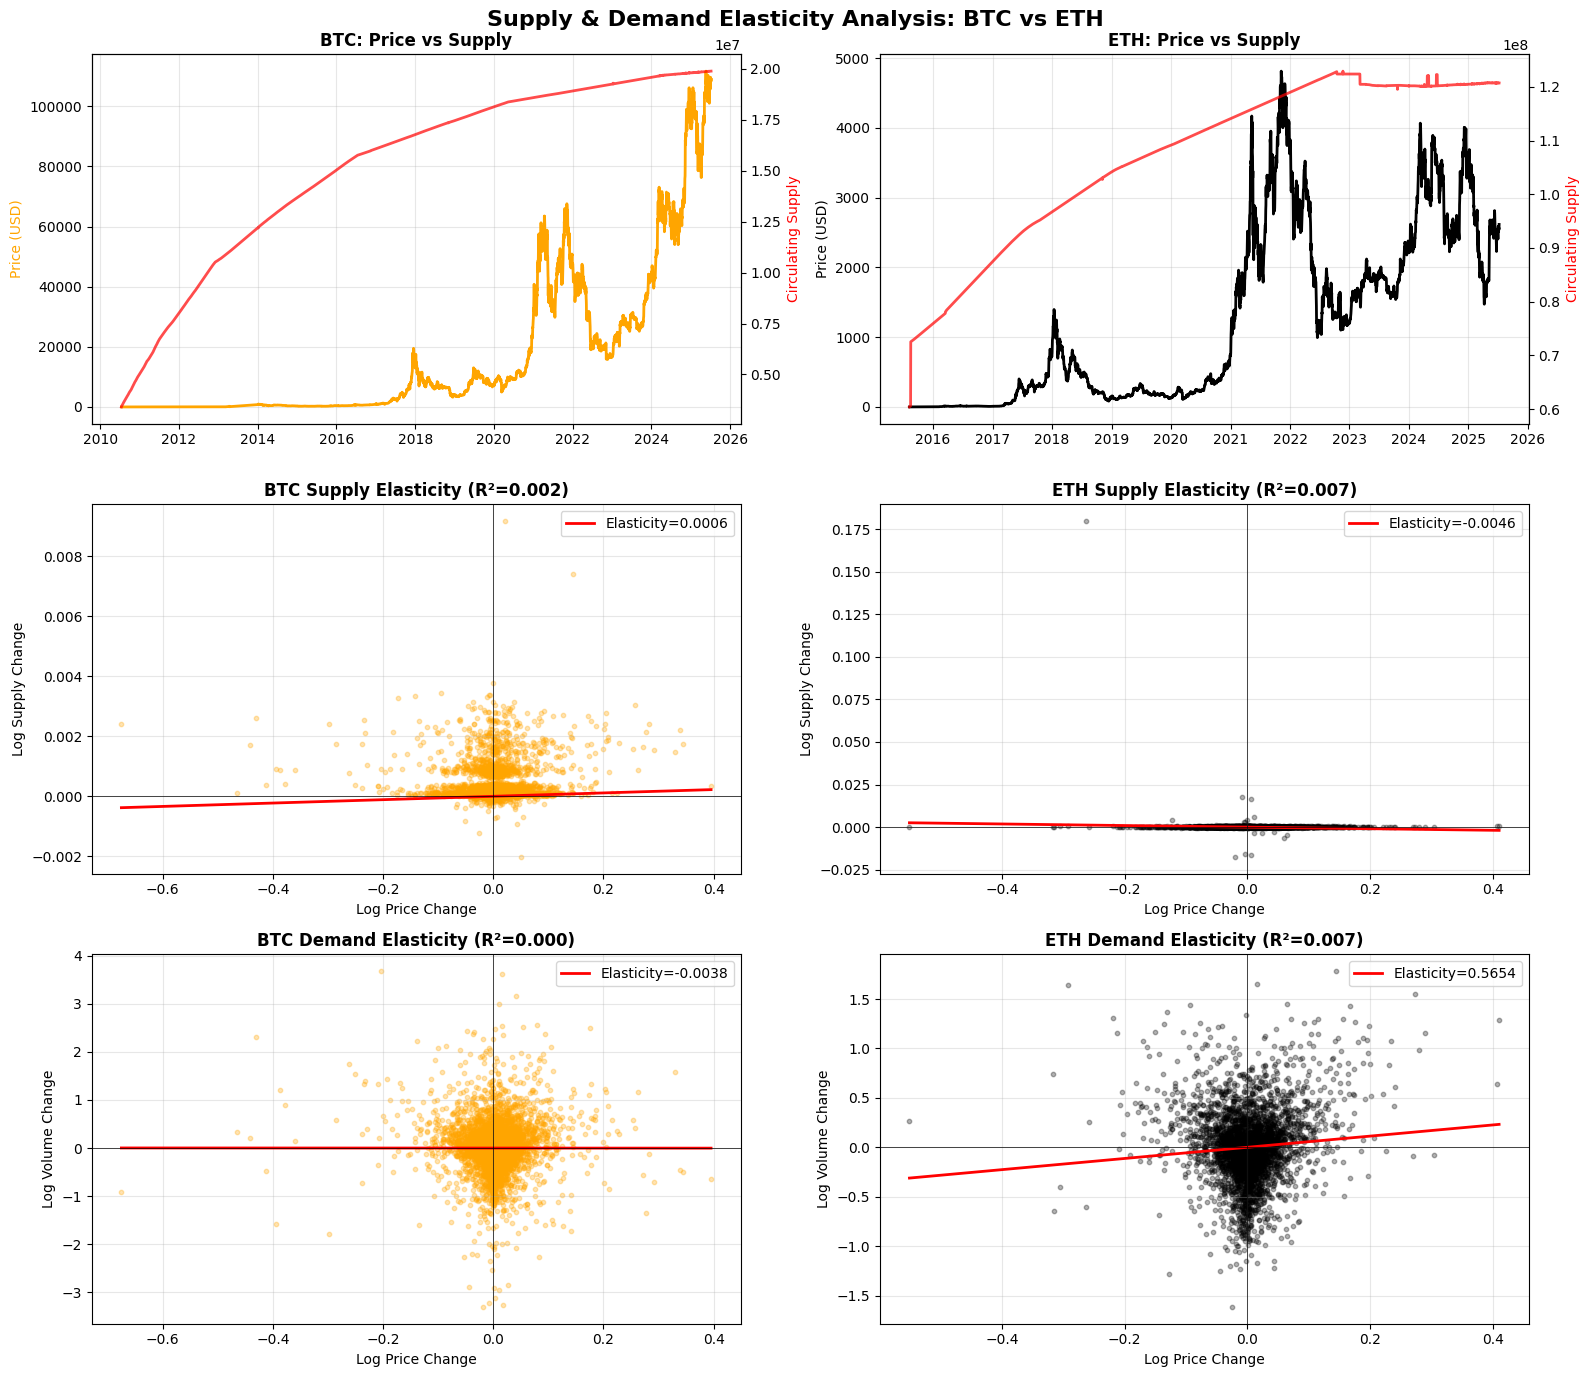

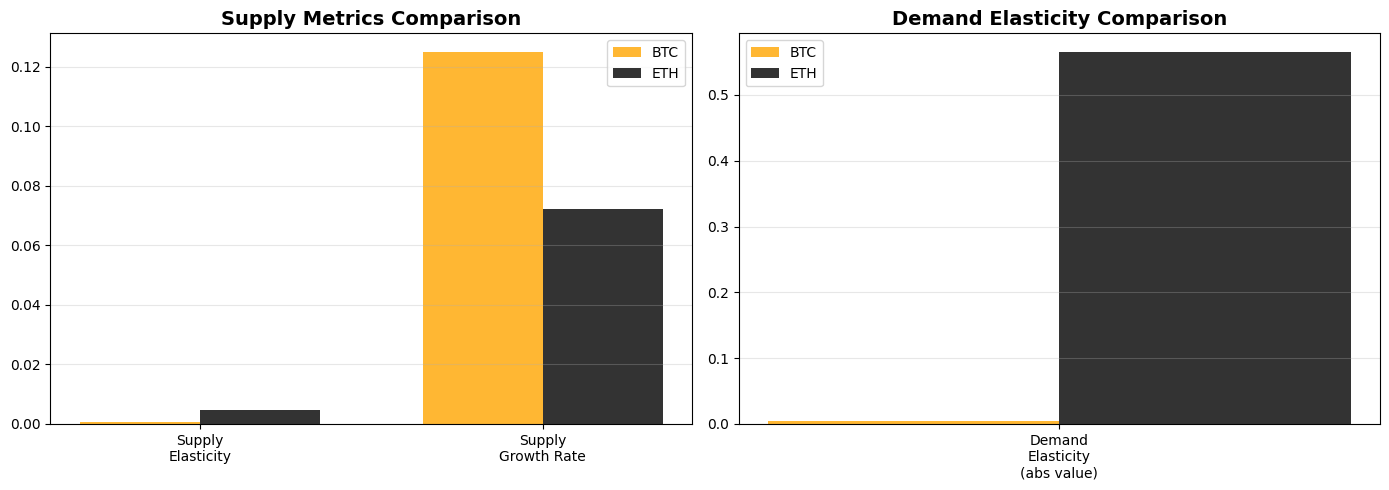

In [ ]:
results = calculate_elasticity(btc_df.drop(columns="Halving"), eth_df)
plot_elasticity_analysis(results)

This elasticity analysis reveals that both Bitcoin (BTC) and Ethereum (ETH) exhibit highly inelastic supply, confirming that their circulating supplies are largely unaffected by price fluctuations—typical of capped or algorithmically governed cryptocurrencies. However, ETH’s slightly negative elasticity (–0.0046) suggests even less responsiveness than BTC’s near-zero elasticity (0.0006). On the demand side, BTC shows virtually no sensitivity to price (–0.0038), implying a relatively stable user and investor base, while ETH’s positive elasticity (0.5654) indicates a more speculative market where higher prices stimulate greater trading volume—consistent with momentum or FOMO-driven behavior. Overall, BTC’s price is shaped mainly by scarcity and long-term demand fundamentals, whereas ETH’s market dynamics are more reactive and trader-driven, leading to sharper demand shifts during bullish cycles.

# **Final Interpretation**
The analysis in the file explores how supply constraints and demand variations drive price movements in cryptocurrencies like Bitcoin and Ethereum. When supply is limited—as in Bitcoin’s fixed cap—price tends to rise when demand increases, since fewer coins are available to meet buyers’ interest. In contrast, assets with more flexible supply or higher market liquidity, like Ethereum, may show smoother price adjustments. The study’s volatility and elasticity metrics illustrate that tighter supply amplifies sensitivity to demand changes, causing sharper price swings, while more elastic supply or stronger market depth stabilizes prices against short-term fluctuations. Overall, price dynamics emerge from how quickly and strongly market demand interacts with each asset’s supply limits